# Dog and Cat Classification

In [1]:
import torch
import torch.nn as nn


In [2]:
from pathlib import Path

data_path = Path('data/')
image_path = data_path / 'dog_cat'

In [3]:
import os 
def walk_through(dir_path):

    for dirpath, dirname, filename in os.walk(dir_path):
        print(f'There are {len(dirname)} directories and {len(filename)} files in {dirpath}')
walk_through(data_path)

There are 1 directories and 0 files in data
There are 2 directories and 0 files in data\dog_cat
There are 2 directories and 0 files in data\dog_cat\test_set
There are 0 directories and 1012 files in data\dog_cat\test_set\cats
There are 0 directories and 1013 files in data\dog_cat\test_set\dogs
There are 2 directories and 0 files in data\dog_cat\training_set
There are 0 directories and 4001 files in data\dog_cat\training_set\cats
There are 0 directories and 4006 files in data\dog_cat\training_set\dogs


In [4]:
test_dir = image_path / 'test_set'
train_dir = image_path / 'training_set'

In [5]:
test_dir

WindowsPath('data/dog_cat/test_set')

Image Height: 382
Image Width: 499
Image Class : dogs
Random Image Path: data\dog_cat\training_set\dogs\dog.2421.jpg


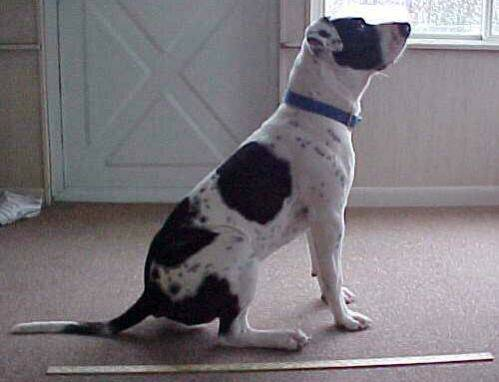

In [6]:
import random 
from PIL import Image

# random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path =random.choice(image_path_list)
image_class = random_image_path.parent.stem
img = Image.open(random_image_path)

print(f"Image Height: {img.height}")
print(f"Image Width: {img.width}")
print(f"Image Class : {image_class}")
print(f"Random Image Path: {random_image_path}")
img

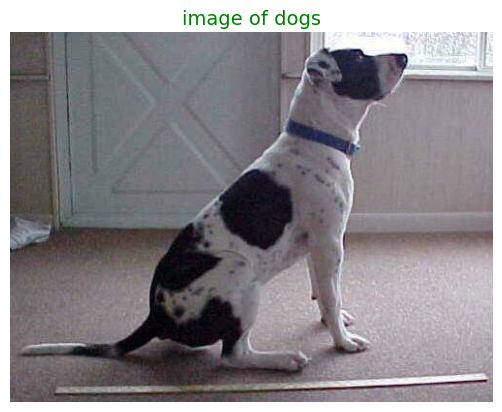

In [7]:
import matplotlib.pyplot as plt
import numpy as np

img_as_array = np.asarray(img)

plt.imshow(img_as_array)
plt.axis(False)
plt.title(f'image of {image_class}',c='g', fontsize=14);

In [8]:
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

data_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])


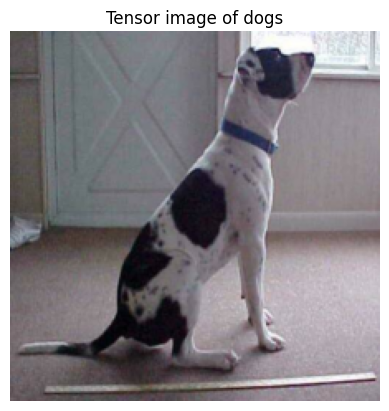

In [9]:
tensor_img = data_transform(img)
tensor_img = tensor_img.permute(1,2,0)
plt.imshow(tensor_img)
plt.title(f'Tensor image of {image_class}');
plt.axis(False);

In [10]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    # transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [11]:
from torchvision.datasets import ImageFolder
train_data = ImageFolder(root=train_dir,
                               transform=train_transform,
                               target_transform=None)
test_data = ImageFolder(root=test_dir,
                              transform=test_transform,
                              target_transform=None)
train_data

Dataset ImageFolder
    Number of datapoints: 8005
    Root location: data\dog_cat\training_set
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [12]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data,
                              batch_size=32,
                              shuffle=True)
test_dataloader = DataLoader(test_data,
                             batch_size=32,
                             shuffle=False)


In [13]:
train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1a799530c20>,
 <torch.utils.data.dataloader.DataLoader at 0x1a7a198cfb0>)

In [14]:
def display_random_images(dataset:torch.utils.data.dataset.Dataset,
                          classes: list[str],
                          n: int =10,
                          display_shape: bool=True,
                          seed: int= None):
    if n>10:
        n=10
        print("display shape must be 10 or less than 10")
        display_shape = False
    if seed: 
        random.seed(seed)
    
    random_sample_img = random.sample(range(len(dataset)),k=n)

    plt.figure(figsize=(20,10))

    for i, sample_img in enumerate(random_sample_img):

        target_img, target_label = dataset[sample_img][0], dataset[sample_img][1]

        target_img_adjust = target_img.permute(1,2,0)

        plt.subplot(1,n,i+1)
        plt.imshow(target_img_adjust)
        if classes:
            title = f"class: {classes[target_label]}"
            if display_shape:
                title = title + f"\nshape: {target_img_adjust.shape}"
        plt.title(title,fontsize= 14,c='y')
        plt.axis("off");


In [15]:
class_names = train_data.classes

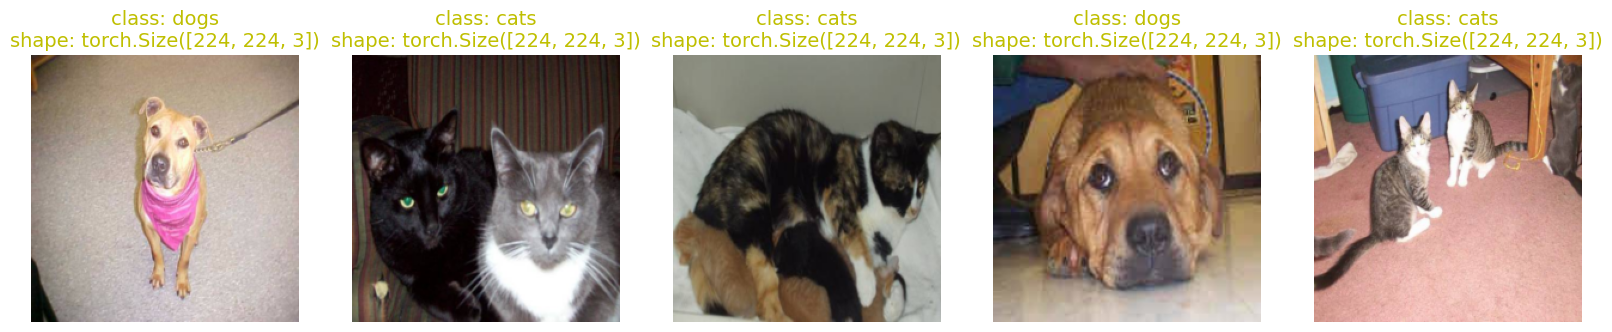

In [16]:
display_random_images(train_data,
                      classes=class_names,
                      n=5,
                      seed=42)

In [17]:
import torch.nn as nn

class BetterCNN(nn.Module):
    def __init__(self, input_channels=3, num_classes=2):
        super().__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # /2

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # /4

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # /8
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # avoids fixed size issue
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [18]:
tensor_img.shape

torch.Size([224, 224, 3])

In [19]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [20]:
model = BetterCNN().to(device)

In [21]:
model

BetterCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): AdaptiveAvgPool2d(output_size=(1, 1))
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=128, out_features=6

In [22]:
img, label = next(iter(train_dataloader))
img.shape

torch.Size([32, 3, 224, 224])

In [23]:
tensor_img = model(img.to(device))

In [24]:
def train_step(model: torch.nn.Module,
               dataset: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    model.eval()
    train_loss, train_acc = 0,0 
    for batch, (X,y) in enumerate(dataset):

        X, y = X.to(device), y.to(device)

        y_logits = model(X)

        loss = loss_fn(y_logits,y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred = torch.argmax(torch.softmax(y_logits,dim=1), dim=1)
        train_acc += (y_pred == y).sum().item()/len(y_logits)
    train_loss = train_loss / len(dataset)
    train_acc = train_acc / len(dataset)
    return train_loss, train_acc

In [25]:
def test_step(model: torch.nn.Module,
              dataset: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    test_loss, test_acc = 0,0
    for batch, (X,y) in enumerate(dataset):
        with torch.inference_mode():
            X,y = X.to(device), y.to(device)
            
            y_logits = model(X)

            loss = loss_fn(y_logits,y)
            test_loss += loss.item()

            y_pred = torch.argmax(torch.softmax(y_logits,dim=1), dim=1)
            test_acc += (y_pred == y).sum().item()/len(y_logits)
    test_acc = test_acc / len(dataset)
    test_loss = test_loss / len(dataset)
    return test_loss, test_acc

In [26]:
from torch import optim

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(),lr=0.001)

In [27]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataset=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataset=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [28]:
train(model=model,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=5)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6897 | train_acc: 0.5357 | test_loss: 0.6850 | test_acc: 0.5751
Epoch: 2 | train_loss: 0.6710 | train_acc: 0.5790 | test_loss: 0.6609 | test_acc: 0.6013
Epoch: 3 | train_loss: 0.6560 | train_acc: 0.6029 | test_loss: 0.6567 | test_acc: 0.5899
Epoch: 4 | train_loss: 0.6352 | train_acc: 0.6353 | test_loss: 0.6081 | test_acc: 0.6683
Epoch: 5 | train_loss: 0.6053 | train_acc: 0.6680 | test_loss: 0.5858 | test_acc: 0.6825


{'train_loss': [0.689710831974607,
  0.6710015901056419,
  0.6560263225281856,
  0.6351890376364567,
  0.605260968564516],
 'train_acc': [0.5357071713147411,
  0.5790338645418327,
  0.6028635458167331,
  0.635308764940239,
  0.6679780876494024],
 'test_loss': [0.6849642898887396,
  0.6609078999608755,
  0.6566884154453874,
  0.6080525116994977,
  0.5857654688879848],
 'test_acc': [0.5751255580357143,
  0.6012834821428571,
  0.5899135044642857,
  0.6683175223214286,
  0.6824776785714286]}

In [29]:
def model_eval(model:torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module):
    
    pre_loss= 0
    test_pred = []
    for batch, (X,y) in enumerate(dataloader):
        X,y = X.to(device), y.to(device)
        model.eval()
        with torch.inference_mode():
            
            y_logits = model(X)
            y_pred = torch.argmax(torch.softmax(y_logits, dim=1),dim=1)
            test_pred.append(y_pred)
            loss = loss_fn(y_logits,y)
            pre_loss += loss.item()
    pre_loss /= len(dataloader)
    print(pre_loss)
    return test_pred


In [30]:
model_eval(model=model,
           dataloader=test_dataloader,
           loss_fn=loss_fn)


0.5857654688879848


[tensor([1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
         0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
         1, 1, 0, 0, 0, 0, 0, 0], device='cuda:0'),
 tensor([1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
         1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
 tensor([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
         0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0'),
 tensor([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
 tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
 tensor([0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 

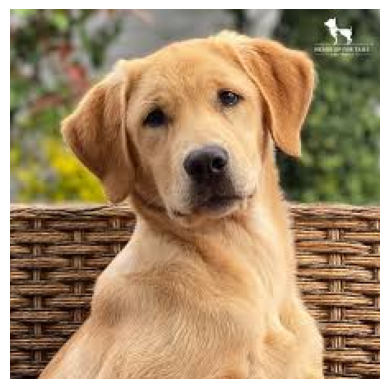

In [31]:
from PIL import Image

img = Image.open("dog.jpeg")

plt.imshow(img)
plt.axis(False);

In [32]:
img_as_array = np.asarray(img)
img_as_array

array([[[156, 172, 127],
        [162, 178, 131],
        [172, 190, 138],
        ...,
        [115, 122, 104],
        [122, 130, 109],
        [146, 150, 135]],

       [[154, 166, 126],
        [160, 175, 132],
        [171, 187, 140],
        ...,
        [109, 116,  98],
        [117, 125, 104],
        [144, 148, 133]],

       [[155, 164, 135],
        [162, 171, 140],
        [173, 183, 148],
        ...,
        [100, 107,  89],
        [110, 118,  97],
        [138, 142, 127]],

       ...,

       [[ 43,  28,  25],
        [ 28,  13,  10],
        [ 18,   3,   0],
        ...,
        [ 70,  43,  26],
        [ 79,  52,  33],
        [ 82,  50,  35]],

       [[ 68,  53,  50],
        [ 78,  63,  60],
        [ 80,  65,  62],
        ...,
        [ 35,   9,   0],
        [ 36,   8,   0],
        [ 54,  22,   9]],

       [[ 88,  70,  60],
        [ 65,  47,  37],
        [ 58,  41,  33],
        ...,
        [ 60,  31,  23],
        [ 39,   9,   0],
        [ 95,  58,  39]]

In [33]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()]
)
tensor = transform(img)
tensor.shape

torch.Size([3, 224, 224])

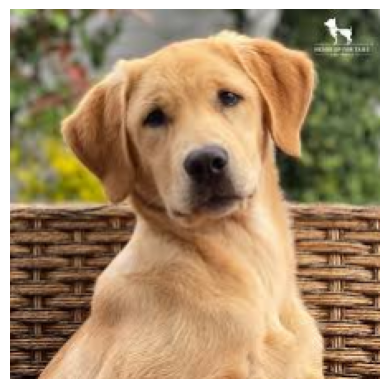

In [34]:
plt.imshow(tensor.permute(1,2,0))
plt.axis(False);

In [35]:
tensor = tensor.unsqueeze(dim=0)
tensor.shape

torch.Size([1, 3, 224, 224])

In [36]:
tensor = tensor.to(device)
y_pred = model(tensor)
y_pred = y_pred.argmax(dim=1)
y_pred

tensor([1], device='cuda:0')

In [37]:
class_names[y_pred]

'dogs'

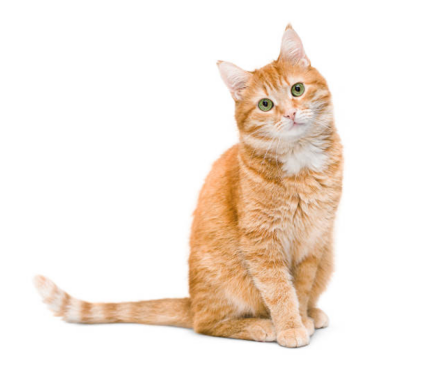

In [38]:
cat_image = Image.open('cat1.jpg')
plt.imshow(cat_image)
plt.axis(False);

In [39]:
cat_tensor = transform(cat_image)
cat_tensor.shape

torch.Size([3, 224, 224])

In [40]:
cat_tensor = cat_tensor.unsqueeze(dim = 0)
cat_tensor = cat_tensor.to(device)
cat_tensor.shape

torch.Size([1, 3, 224, 224])

In [41]:
y_pred = model(cat_tensor)
y_pred = y_pred.argmax(dim=1)
y_pred

tensor([0], device='cuda:0')

In [42]:
class_names[y_pred]

'cats'